In [584]:
# import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

In [585]:
# using LinearAlgebra
# using PyPlot
# using Printf
# using Random

In [586]:
include("../LibTinyMPC_clean.jl")

export_mat_to_c (generic function with 1 method)

In [587]:
#Rocket landing
NSTATES = 6
NINPUTS = 3
NHORIZON = 20
NTOTAL = 301

rho = 1e-1
Kinf = zeros(NINPUTS,NSTATES)
Pinf = zeros(NSTATES,NSTATES)
Quu_inv = zeros(NINPUTS,NINPUTS)
AmBKt = zeros(NSTATES,NSTATES)
APf = zeros(NSTATES)
BPf = zeros(NINPUTS)
my_cache = TinyCache(rho, Kinf, Pinf, Quu_inv, AmBKt, APf, BPf)

abs_pri_tol = 1e-2
abs_dua_tol = 1e-2
max_iter = 250
check_termination = 1
en_state_bound = 1  # ENABLE CONSTRAINTS OR NOT
en_input_bound = 1
en_state_soc = 0
en_input_soc = 1
my_stgs = TinySettings(abs_pri_tol, abs_dua_tol, max_iter, check_termination, en_state_bound, en_input_bound, en_state_soc, en_input_soc)

umin = -10.0*ones(NINPUTS, NHORIZON-1)
umax = 105*ones(NINPUTS, NHORIZON-1)
xmin = repeat([-5; -5; -0.5; -10; -10; -20], 1, NHORIZON)
xmax = repeat([5; 5; 100.0; 10; 10; 20], 1, NHORIZON)
z = zeros(NINPUTS, NHORIZON-1)
znew = zeros(NINPUTS, NHORIZON-1)
v = zeros(NSTATES, NHORIZON)
vnew = zeros(NSTATES, NHORIZON)
y = zeros(NINPUTS, NHORIZON-1)
g = zeros(NSTATES, NHORIZON)
my_bounds = TinyBounds(umin, umax, xmin, xmax, z, znew, v, vnew, y, g)

ncu = 1
ncx = 0
cu = [0.4, 0]  # 0.3 is the thrust coefficient
cx = [0, 0]
qcu = [3, 0]  # 3 is the dimensions of 1st cone
qux = [0, 0]
Acu = [1, 0]
Acx = [0, 0]
zc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
zcnew = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vcnew = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
yc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
gc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
my_socs = TinySocs(ncu, ncx, cu, cx, qcu, qux, Acu, Acx, zc, zcnew, vc, vcnew, yc, gc)

x = zeros(NSTATES, NHORIZON)
u = zeros(NINPUTS, NHORIZON-1)
q = zeros(NSTATES, NHORIZON)
r = zeros(NINPUTS, NHORIZON-1)
p = zeros(NSTATES, NHORIZON)
d = zeros(NINPUTS, NHORIZON-1)
pri_res_state = 1.0
pri_res_input = 1.0
dua_res_state = 1.0
dua_res_input = 1.0
status = 0
iter = 0
Q = 1e3*I(NSTATES)
R = 1e0*I(NINPUTS)
Adyn = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
Bdyn = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
fdyn = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905] * 1

h = 0.05
t = h*(0:NTOTAL-1)
Xref = zeros(NSTATES, NTOTAL)
x0 = [4, 2, 20, -3, 2.8, -5.0]  # INITIAL STATE
# x0 = [4, 2, 20, -2, 1, -4.0]
x[:,1] = 1*x0
xg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for k = 1:NTOTAL
  Xref[:,k] = x0 + (xg - x0)*(k-1)/(NTOTAL-1)
end
Uref = repeat([0; 0; 10.0], 1, NTOTAL-1) 
Xref_hrz = 1*Xref[:,1:NHORIZON]
Uref_hrz = 1*Uref[:,1:NHORIZON-1]
# Could provide a better reference from other solvers

Qu = zeros(NINPUTS, NINPUTS)
my_work = TinyWorkspace(x, u, q, r, p, d, pri_res_state, pri_res_input, dua_res_state, dua_res_input, status, iter, Q, R, Adyn, Bdyn, fdyn, Xref_hrz, Uref_hrz, Qu, my_bounds, my_socs)

solver = TinySolver(my_stgs, my_cache, my_work)

TinySolver(TinySettings(0.01, 0.01, 250, 1, 1, 1, 0, 1), TinyCache(0.1, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), TinyWorkspace([4.0 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0; … ; 2.8 0.0 … 0.0 0.0; -5.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 1.0, 1.0, 1.0, 1.0, 0, 0, [1000.0 0.0 … 0.0 0.0; 0.0 1000.0 … 0.0 0.0; … ; 0.0 0.0 … 1000.0 0.0; 0.0 0.0 … 0.0 1000.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 … 0.0 

In [588]:
compute_cache!(solver)

6-element Vector{Float64}:
  -79895.30738732898
  -66739.96361492114
 -461784.2344279395
     607.5432291360557
  -36290.12024220251
  -82064.35793983261

In [595]:
# MPC loop
Random.seed!(1234)
Xhist = zeros(NSTATES, NTOTAL)
Xhist[:,1] .= x0
Uhist = zeros(NINPUTS, NTOTAL-1)
NRUNS = NTOTAL-NHORIZON-1  
for i = 1:NRUNS
    # i%10 == 0 && print("i = ", i, "\n")
    # Get measurements
    pos_norm = norm(Xhist[1:3, i], Inf) / 1e2 # 1% noise
    vel_norm = norm(Xhist[4:6, i], Inf) / 1e4 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    Xhist[:,i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    solver.workspace.x[:,1] .= Xhist[:,i] 
    # print("x = ", solver.workspace.x[:,1], "\n")

    # Update references
    solver.workspace.Xref .= Xref[:,i:i+NHORIZON-1]
    solver.workspace.Uref .= Uref[:,i:i+NHORIZON-2]
    # print("xref = ", solver.workspace.Xref, "\n")
    
    # Solve
    solve_admm!(solver)
    Uhist[:,i] .= solver.workspace.u[:,1]
    # print("u = ", Uhist[:,i], "\n")

    # Simulate
    Xhist[:,i+1] .= Adyn*Xhist[:,i] + Bdyn*Uhist[:,i] + fdyn
end

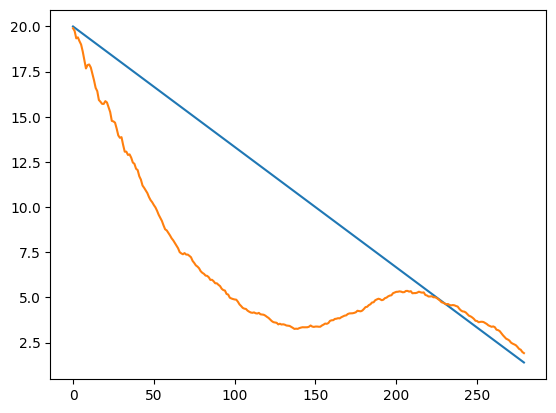

In [590]:
fig = plt.figure()
plot(Xref[3,1:NRUNS]) # z
plot(Xhist[3,1:NRUNS])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

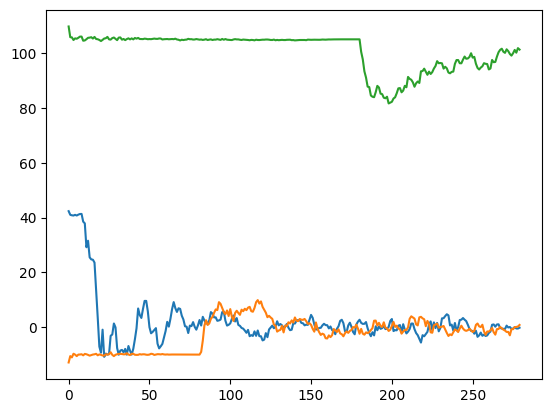

In [591]:
print("max control = ", maximum(Uhist[:, 1:NRUNS]), "\n")
print("min control = ", minimum(Uhist[:, 1:NRUNS]), "\n")
fig = plt.figure()
plot(Uhist[1, 1:NRUNS])
plot(Uhist[2, 1:NRUNS])
plot(Uhist[3, 1:NRUNS])
fig

In [592]:
vio_count = 0
for idx in 1:NRUNS
    (sqrt(Uhist[1,idx]^2 + Uhist[2,idx]^2) - cu[1]*Uhist[3,idx] >= 1e-2) && (vio_count += 1) 
end
vio_count

6

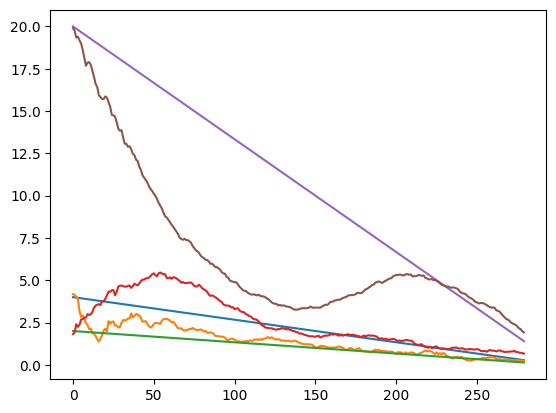

In [593]:
print("max state = ", maximum(Xhist[2,:]))
fig = plt.figure()
plot(Xref[1,1:NRUNS])
plot(Xhist[1,1:NRUNS])
plot(Xref[2,1:NRUNS]) 
plot(Xhist[2,1:NRUNS])
plot(Xref[3,1:NRUNS]) 
plot(Xhist[3,1:NRUNS])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

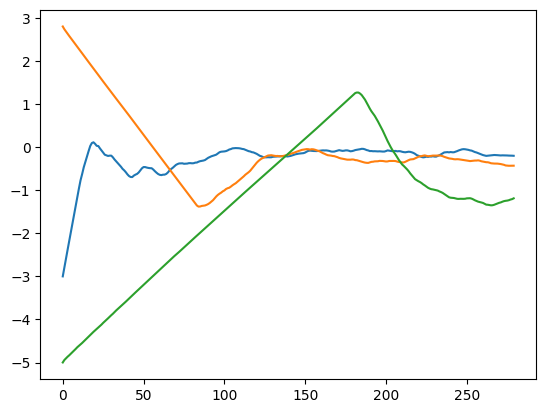

In [594]:
fig = plt.figure()
plot(Xhist[4,1:NRUNS])
plot(Xhist[5,1:NRUNS])
plot(Xhist[6,1:NRUNS])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig